## Contents:
- [Define Functions](#Define-Functions)
- [Importing Scrap Data](#Importing-Scrap-Data)
- [Inspect & Cleaning](#Inspect-&-Cleaning)
- [EDA](#EDA)
- [Target and feature (Post)](#Target-and-feature-(Post))
- [Logistic Regression](#Logistic-Regression)
- [MultinomialNB](#MultinomialNB)
- [Gridsearch & Pipeline](#Gridsearch-&-Pipeline)
- [Evaluation Summary](#Evaluation-Summary)
- [Conclusion & Recommendation](#Conclusion-&-Recommendation)

In [2]:
# import libraries

# maths
import scipy.stats as stats
import numpy as np
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from wordcloud import WordCloud
%matplotlib inline

# modelling
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score,mean_squared_error,confusion_matrix,accuracy_score,roc_auc_score
from sklearn.pipeline import make_pipeline,Pipeline

# nlp
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re



## Define Functions

In [3]:
lem = WordNetLemmatizer()

def preprocessing(text):
    #Remove Hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text) # Remove hyperlinks 
    
    #Remove non-letters.
    text = re.sub("[^a-zA-Z]", " ", text)
    
    #Convert to lower case, split into individual words.
    text = text.lower().split()
    
   #Instantiate lemmatize
    lemmatize_words = [lem.lemmatize(i) for i in text]
    
    # Remove stop words.
    meaningful_words = [x for x in lemmatize_words if x not in stopwords.words('english')]
    
    # Join the words back into one string separated by space, 
    return(" ".join(meaningful_words))

In [4]:
# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

## Importing Scrap Data

In [5]:
#Opening dataset from reddit API

df_anxiety = pd.read_csv('./Dataset/anxiety.csv')
df_depression = pd.read_csv('./Dataset/depression_dark.csv')

In [6]:
df_anxiety.shape

(1253, 104)

In [7]:
df_depression.shape

(1246, 100)

## Inspect & Cleaning 

In [8]:
df_anxiety.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id,post_hint,preview
0,NaN,Anxiety,"""Happy Sunday! What does your week look like?\...",t2_6l4z3,False,NaN,0,False,"Sunday General Chat Thread - March 01, 2020",[],...,True,https://www.reddit.com/r/Anxiety/comments/fbt8...,335083,1.583065e+09,0,NaN,False,NaN,NaN,NaN
1,NaN,Anxiety,"Hello, everyone. We understand that there is a...",t2_j1gdm,False,NaN,0,False,Coronavirus Megathread,[],...,True,https://www.reddit.com/r/Anxiety/comments/eupi...,335083,1.580140e+09,0,NaN,False,a3804d3a-73b8-11e5-8bc1-0e7d1b48e76b,NaN,NaN
2,NaN,Anxiety,That is all.,t2_e480f,False,NaN,0,False,Fuck company events that make you speak in fro...,[],...,False,https://www.reddit.com/r/Anxiety/comments/fein...,335083,1.583523e+09,0,NaN,False,NaN,NaN,NaN
3,NaN,Anxiety,Depression makes me want to stay in bed and sl...,t2_3m7qz4eg,False,NaN,1,False,Depression and anxiety together is the worst.,[],...,False,https://www.reddit.com/r/Anxiety/comments/fe8b...,335083,1.583470e+09,0,NaN,False,96ff8fbc-f4b0-11e4-ac07-22000b39c343,NaN,NaN
4,NaN,Anxiety,I constantly feel guilty. I can’t think of any...,t2_510dlbra,False,NaN,0,False,I feel guilty about absolutely everything,[],...,False,https://www.reddit.com/r/Anxiety/comments/feiq...,335083,1.583523e+09,0,NaN,False,19ddd408-76a1-11e5-acb1-0ea7f7edc7ed,NaN,NaN


In [9]:
df_depression.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday
0,NaN,depression,We understand that most people who reply immed...,t2_1t70,False,NaN,0,False,Our most-broken and least-understood rules is ...,[],...,/r/depression/comments/doqwow/our_mostbroken_a...,no_ads,True,https://www.reddit.com/r/depression/comments/d...,611730,1.572361e+09,0,NaN,False,NaN
1,NaN,depression,Welcome to /r/depression's check-in post - a p...,t2_64qjj,False,NaN,0,False,Regular Check-In Post,[],...,/r/depression/comments/exo6f1/regular_checkin_...,no_ads,True,https://www.reddit.com/r/depression/comments/e...,611730,1.580649e+09,0,NaN,False,NaN
2,NaN,depression,I've been feeling really depressed and lonely ...,t2_17aooz,False,NaN,0,False,I hate it so much when you try and express you...,[],...,/r/depression/comments/fedwbi/i_hate_it_so_muc...,no_ads,False,https://www.reddit.com/r/depression/comments/f...,611730,1.583503e+09,0,NaN,False,NaN
3,NaN,depression,"First off, what a stupid fucking question to a...",t2_ptslwif,False,NaN,0,False,"You ever get asked the ""where do you see yours...",[],...,/r/depression/comments/fekv9y/you_ever_get_ask...,no_ads,False,https://www.reddit.com/r/depression/comments/f...,611730,1.583531e+09,0,NaN,False,NaN
4,NaN,depression,Seems like when anyone else in my life is feel...,t2_2e3v4lor,False,NaN,0,False,"I'm tired of caring about other people, but no...",[],...,/r/depression/comments/feh19t/im_tired_of_cari...,no_ads,False,https://www.reddit.com/r/depression/comments/f...,611730,1.583516e+09,0,NaN,False,NaN


In [10]:
#Selecting relevant columns

df_anxiety_musk = df_anxiety.loc[:,['author_fullname','selftext','title']]
df_anxiety_musk = df_anxiety_musk.iloc[2:,]
df_anxiety_musk.head()

,author_fullname,selftext,title
2,t2_e480f,That is all.,Fuck company events that make you speak in fro...
3,t2_3m7qz4eg,Depression makes me want to stay in bed and sl...,Depression and anxiety together is the worst.
4,t2_510dlbra,I constantly feel guilty. I can’t think of any...,I feel guilty about absolutely everything
5,t2_5rsqkiod,"Woah, I'm so dumb. I never realized that I'm m...",I just realized that I'm the one whose putting...
6,t2_a6gjh,It’s absolutely terrifying and disturbing. I f...,Does anyone else have really disturbing intrus...


In [11]:
df_depression_musk = df_depression.loc[:,['author_fullname','selftext','title']]
df_depression_musk = df_depression_musk.iloc[2:,]
df_depression_musk.head()

,author_fullname,selftext,title
2,t2_17aooz,I've been feeling really depressed and lonely ...,I hate it so much when you try and express you...
3,t2_ptslwif,"First off, what a stupid fucking question to a...","You ever get asked the ""where do you see yours..."
4,t2_2e3v4lor,Seems like when anyone else in my life is feel...,"I'm tired of caring about other people, but no..."
5,t2_5v2j4itq,I literally broke down crying and asked to go ...,I went to the hospital because I was having re...
6,t2_ww40a,"\nWhy? Because if it does work, then I have to...",I secretly don’t want my antidepressant medica...


In [12]:
#Remove away duplicate author_fullname

df_anxiety_musk = df_anxiety_musk.drop_duplicates(subset = 'author_fullname')

df_depression_musk = df_depression_musk.drop_duplicates(subset = 'author_fullname')


In [13]:
print(df_anxiety.shape)
print(df_anxiety_musk.shape)

(1253, 104)
(901, 3)


In [14]:
print(df_depression.shape)
print(df_depression_musk.shape)

(1246, 100)
(874, 3)


In [15]:
#Check for Null posts
df_anxiety_musk.isnull().sum()

author_fullname     1
selftext           31
title               0
dtype: int64

In [16]:
df_depression_musk.isnull().sum()

author_fullname    1
selftext           1
title              0
dtype: int64

In [17]:
#Remove away Null

df_anxiety_musk.dropna(subset=['selftext'],axis=0,inplace=True)


In [18]:
df_anxiety_musk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 870 entries, 2 to 1002
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   author_fullname  869 non-null    object
 1   selftext         870 non-null    object
 2   title            870 non-null    object
dtypes: object(3)
memory usage: 27.2+ KB


In [19]:
df_depression_musk.dropna(subset=['selftext'],axis=0,inplace=True)

In [20]:
df_depression_musk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 873 entries, 2 to 920
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   author_fullname  872 non-null    object
 1   selftext         873 non-null    object
 2   title            873 non-null    object
dtypes: object(3)
memory usage: 27.3+ KB


Since we are concentrating our model based on the posts on Reddit therefore, it makes no sense to retain empty post in the DataFrame. But we are retaining 'author_fullname' as their post might not be empty and may provide valuable data. 

In [21]:
#Clean Anxiety Text
anxiety_clean_post = []

for text in df_anxiety_musk['selftext']:
    anxiety_clean_post.append(preprocessing(text))
    

In [48]:
#Clean Depression Text
depression_clean_post = []

for text in df_depression_musk['selftext']:
    depression_clean_post.append(preprocessing(text))


In [49]:
df_anxiety_musk['selftext'] = anxiety_clean_post
df_depression_musk['selftext'] = depression_clean_post

In [50]:
#Create CSV for clean data

df_anxiety_musk.to_csv('./Dataset/anxiety_clean.csv')
df_depression_musk.to_csv('./Dataset/depression_dark_clean.csv')

## EDA

### Sentiment Analysis

In [32]:
#Sentiment analysis between anxiety posts and depression posts

sentiment = SentimentIntensityAnalyzer()

In [33]:
anxiety_post_sentiment = []

for text in df_anxiety_musk['selftext']:
    score = {}
    score['positive'] = sentiment.polarity_scores(text)['pos']
    score['negative'] = sentiment.polarity_scores(text)['neg']
    score['neutral'] = sentiment.polarity_scores(text)['neu']
    score['compound'] = sentiment.polarity_scores(text)['compound']
    
    anxiety_post_sentiment.append(score)
    
#print(anxiety_post_sentiment)

In [34]:
#Create DataFrame for anxiety_post_sentiment

df_anxiety_post_sentiment = pd.DataFrame(anxiety_post_sentiment)
df_anxiety_post_sentiment.head()

,positive,negative,neutral,compound
0,0.000,0.000,0.000,0.0000
1,0.230,0.210,0.560,0.0844
2,0.338,0.274,0.388,0.7184
3,0.172,0.326,0.503,-0.7236
4,0.074,0.527,0.399,-0.9886


In [35]:
depression_post_sentiment = []

for text in df_depression_musk['selftext']:
    score = {}
    score['positive'] = sentiment.polarity_scores(text)['pos']
    score['negative'] = sentiment.polarity_scores(text)['neg']
    score['neutral'] = sentiment.polarity_scores(text)['neu']
    score['compound'] = sentiment.polarity_scores(text)['compound']
    
    depression_post_sentiment.append(score)
    
#print(depression_post_sentiment)

In [36]:
#Create DataFrame for depression_post_sentiment

df_depression_post_sentiment = pd.DataFrame(depression_post_sentiment)
df_depression_post_sentiment.head()

,positive,negative,neutral,compound
0,0.253,0.220,0.528,0.6800
1,0.224,0.235,0.541,-0.8176
2,0.417,0.240,0.343,0.5719
3,0.037,0.431,0.532,-0.9768
4,0.327,0.197,0.476,0.8268


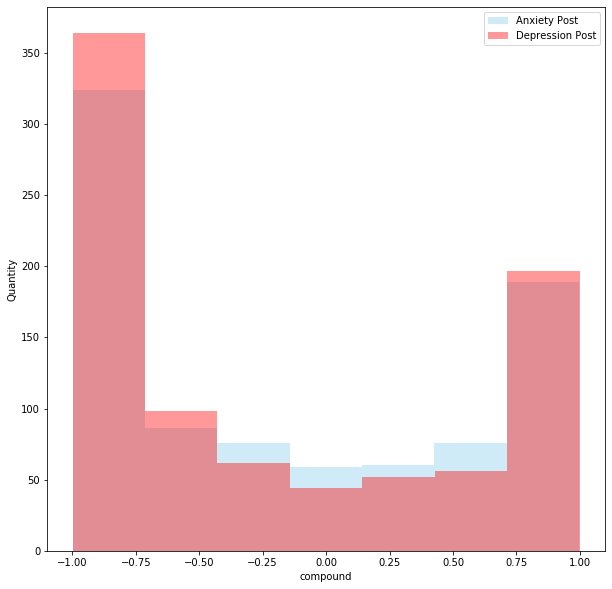

In [37]:
#Plot out the sentiment Depression post VS Anxiety Post
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.distplot( df_anxiety_post_sentiment["compound"] , color="skyblue", label="Anxiety Post",kde=False)
sns.distplot( df_depression_post_sentiment["compound"] , color="red", label="Depression Post",kde=False)
plt.ylabel('Quantity')
ax.legend();


The sentiments between Depression posts and Anxiety posts are relatively similar. The sentiments between each sub Reddits are relatively extreme, they are either extremly positive with a compound score of 1 or extremely negative with a compound score of -1. 

### Top words(Anxiety)

In [42]:
cvec = CountVectorizer(stop_words = 'english')

In [43]:
#Anxiety Posts cvec
df_anxiety_post_cv = pd.DataFrame(cvec.fit_transform(df_anxiety_musk['selftext']).todense(),columns=cvec.get_feature_names())
df_anxiety_post_cv.head()

,00,000,000mg,00pm,01,02,02pm,05,10,100,...,yrs,yummy,zap,zapped,zealand,zero,zoloft,zombie,zone,迷宮物語
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
df_anxiety_post_cv.drop(['wa','ha','ve','don'],axis=1,inplace=True)

In [45]:
top_words_anxiety_post = df_anxiety_post_cv.sum().sort_values(ascending=False).head(20)


In [46]:
#Top words DataFrame for Anxiety post
df_top_words_anxiety_post = top_words_anxiety_post.to_frame(name='count')
df_top_words_anxiety_post['word'] = df_top_words_anxiety_post.index
df_top_words_anxiety_post.reset_index(drop=True, inplace=True)
df_top_words_anxiety_post['frequency'] = df_top_words_anxiety_post['count'] / len(df_anxiety_post_cv.columns) * 100

df_top_words_anxiety_post

,count,word,frequency
0,1062,anxiety,14.027209
1,1034,just,13.657377
2,1007,like,13.300753
3,839,feel,11.081759
4,617,know,8.149518
5,545,really,7.198521
6,479,time,6.326773
7,423,people,5.587109
8,358,want,4.728570
9,341,think,4.504029


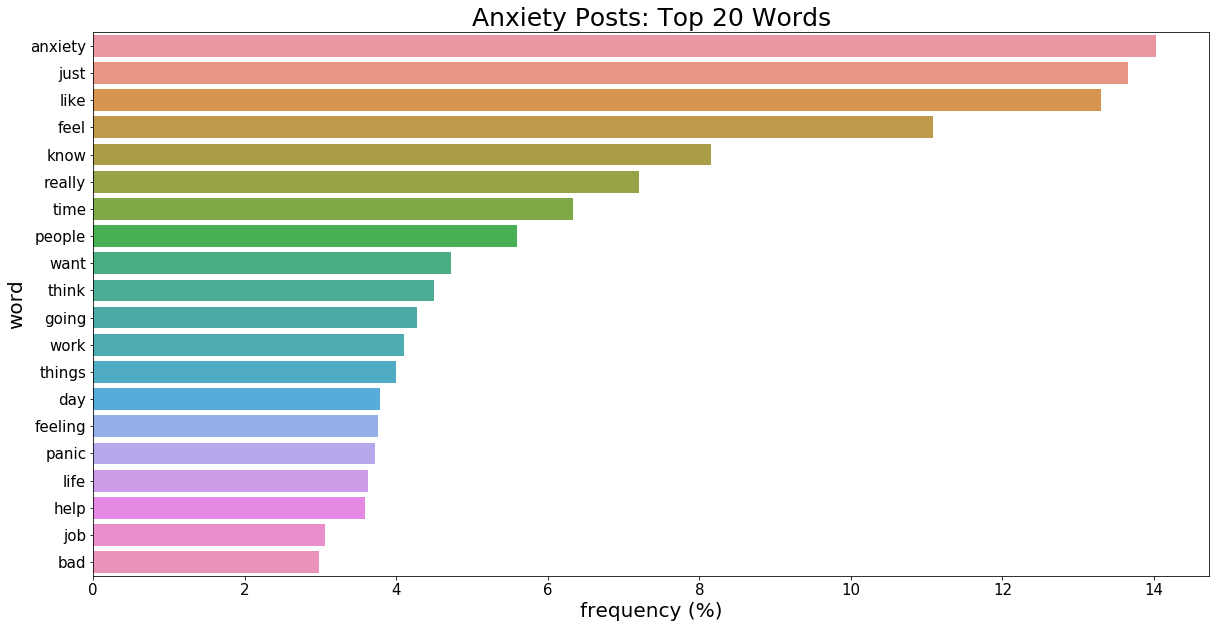

In [47]:
#Plot of Anxiety post
fig = plt.figure(figsize=(20,10))
plt.title('Anxiety Posts: Top 20 Words',fontsize=25)

sns.barplot(x='frequency',y='word',data=df_top_words_anxiety_post)

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)


Words like 'anxiety, people, time' have one of the highest frequencies within anxiety posts. They have a frequeny rate of 6-14% and they are relevant to the topic of anxiety as well.  

### Top words(Depression)

In [55]:
#Depression Posts cvec
df_depression_post_cv = pd.DataFrame(cvec.fit_transform(df_depression_musk['selftext']).todense(),columns=cvec.get_feature_names())
df_depression_post_cv.head()

,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aback,abandoment,abandon,abandoned,abandoning,abandonment,abcesses,abdominal,abide,...,yr,zapped,zero,zest,zinc,zoloft,zombie,zombify,zone,zoned
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
df_depression_post_cv.drop(['aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa','wa','ha'],axis=1,inplace=True)

In [57]:
df_top_words_depression_post = df_depression_post_cv.sum().sort_values(ascending=False).head(20)

In [58]:
#Top words DataFrame for Depression post
df_top_words_depression_post = df_top_words_depression_post.to_frame(name='count')
df_top_words_depression_post['word'] = df_top_words_depression_post.index
df_top_words_depression_post.reset_index(drop=True, inplace=True)
df_top_words_depression_post['frequency'] = df_top_words_depression_post['count'] / len(df_depression_post_cv.columns) * 100

df_top_words_depression_post

,count,word,frequency
0,1167,like,16.940049
1,1124,feel,16.315866
2,805,know,11.685295
3,681,life,9.885324
4,677,time,9.827261
5,674,want,9.783713
6,486,people,7.054725
7,485,thing,7.040209
8,484,year,7.025693
9,480,day,6.967630


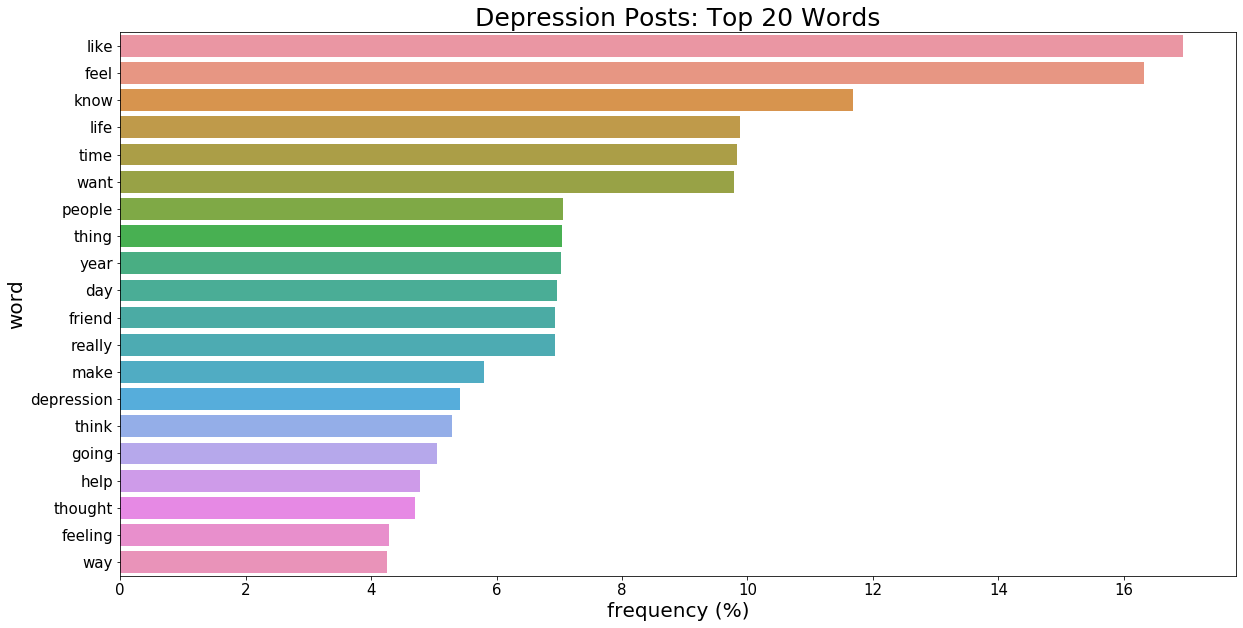

In [59]:
#Plot of depression post
fig = plt.figure(figsize=(20,10))
plt.title('Depression Posts: Top 20 Words',fontsize=25)

sns.barplot(x='frequency',y='word',data=df_top_words_depression_post)

plt.xlabel('frequency (%)',fontsize=20)
plt.ylabel('word',fontsize=20)
plt.tick_params(labelsize=15)

Words like 'life, like, feel' have one of the highest frequency rate of 10-16%. The top 20 common words in depression indicate similarity in words used between anxiety and depression posts. 

### Words Comparison

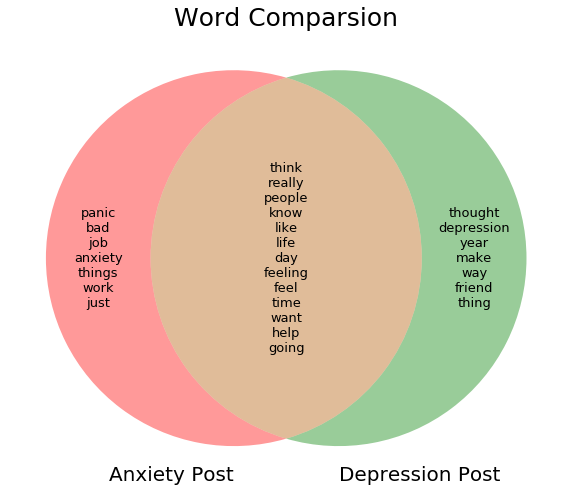

In [60]:
#Anxiety posts VS Depression posts
plt.figure(figsize=(10,10))
plt.title('Word Comparsion',fontsize=25)

set_a = set(df_top_words_anxiety_post['word'][:20])
set_b = set(df_top_words_depression_post['word'][:20])

venn = venn2([set_a,set_b],set_labels=['Anxiety Post','Depression Post'])

venn.get_label_by_id('100').set_text('\n'.join(map(str,set_a-set_b)))
venn.get_label_by_id('110').set_text('\n'.join(map(str,set_a&set_b)))
venn.get_label_by_id('010').set_text('\n'.join(map(str,set_b-set_a)))

venn.get_label_by_id('100').set_size(13)
venn.get_label_by_id('110').set_size(13)
venn.get_label_by_id('010').set_size(13)
venn.get_label_by_id('A').set_size(20)
venn.get_label_by_id('B').set_size(20)


Above venn diagram shows the top 20 words appearing in both Anxiety and Depression posts. It clearly indicates the common and distinct words that appear between both sub Reddits. 

## Target and feature (Post)

In [62]:
#Combining Anxiety post and Depression post
col = ['author_fullname','selftext','title']

df_post = pd.DataFrame(columns = col)
df_post = df_post.append(df_anxiety_musk)
df_post = df_post.append(df_depression_musk)

df_post.reset_index(drop=True,inplace=True)

df_post.tail()

,author_fullname,selftext,title
1738,t2_en5ic,hi guy wanted know really awful vivid nightmar...,Nightmares
1739,t2_1sln3o50,time friend watching funny video laugh smile f...,I feel sad almost always
1740,t2_1d3nehrg,would like share situation presumming ha alrea...,No motivation in job related issues
1741,t2_1t70,understand people reply immediately op invitat...,Our most-broken and least-understood rules is ...
1742,t2_64qjj,welcome r depression check post place take mom...,Regular Check-In Post


In [63]:
#Create target 

df_post['is_anxiety'] = 0
df_post['is_anxiety'].iloc[0:869] = 1
df_post.head()

C:\Users\wilso\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,author_fullname,selftext,title,is_anxiety
0,t2_e480f,,Fuck company events that make you speak in fro...,1
1,t2_3m7qz4eg,depression make want stay bed sleep time alway...,Depression and anxiety together is the worst.,1
2,t2_510dlbra,constantly feel guilty think anything life ass...,I feel guilty about absolutely everything,1
3,t2_5rsqkiod,woah dumb never realized making suffer pressur...,I just realized that I'm the one whose putting...,1
4,t2_a6gjh,absolutely terrifying disturbing feel crazy so...,Does anyone else have really disturbing intrus...,1


In [64]:
#Train test split

X = df_post[['selftext']]
y = df_post['is_anxiety']

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,stratify=y,random_state=42)

In [65]:
X_train.shape, y_train.shape

((1220, 1), (1220,))

In [66]:
X_test.shape, y_test.shape

((523, 1), (523,))

In [67]:
y_train

1191    0
1238    0
1668    0
1117    0
358     1
       ..
1183    0
831     1
569     1
1118    0
1468    0
Name: is_anxiety, Length: 1220, dtype: int64

In [68]:
#Baseline score

y_train.value_counts(normalize = True)

0    0.501639
1    0.498361
Name: is_anxiety, dtype: float64

## Logistic Regression

In [83]:
cvec = CountVectorizer()

X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['selftext']).todense(),columns=cvec.get_feature_names())
X_test_cvec = pd.DataFrame(cvec.transform(X_test['selftext']).todense(),columns=cvec.get_feature_names())

In [84]:
lr = LogisticRegression()

lr_model = lr.fit(X_train_cvec,y_train)

y_pred = lr.predict(X_test_cvec)

In [85]:
#Train score
lr_model.score(X_train_cvec,y_train)

0.9942622950819672

In [86]:
#Test score

lr_model.score(X_test_cvec,y_test)

0.8336520076481836

### Confusion Matrix

In [87]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Confusion Matrix metrics

accuracy = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

print('\n')

print('Accuracy:',round(accuracy,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))

True Negatives: 222
False Positives: 40
False Negatives: 47
True Positives: 214


Accuracy: 0.834
Sensitivity: 0.82
Specificity: 0.847
Precision: 0.843


Logistic Regression test score accuracy has a better score than the baseline score accuracy.

### ROC Curve

In [88]:
pred_proba = [i[1] for i in lr.predict_proba(X_test_cvec)] 

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

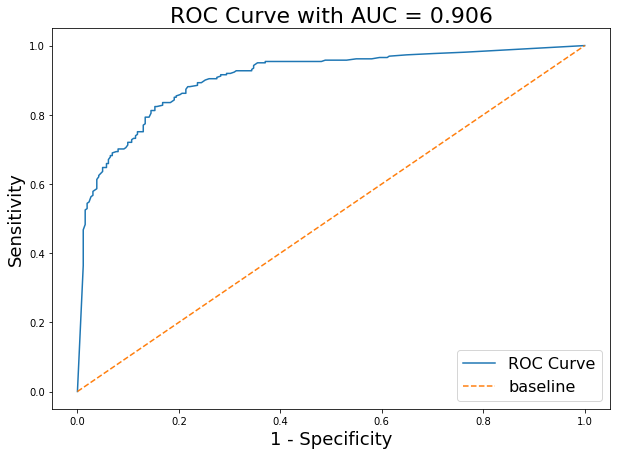

In [89]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')


# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## MultinomialNB

In [77]:
nb = MultinomialNB()

In [65]:
#Fit model
nb.fit(X_train_cvec,y_train)

y_pred = nb.predict(X_test_cvec)

In [66]:
#Train score

nb.score(X_train_cvec,y_train)

0.9385245901639344

In [67]:
#Test score

nb.score(X_test_cvec,y_test)

0.8068833652007649

MultinomialNB has a poorer accuracy as compared to the logistic regression. 

### Confusion Matrix

In [68]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Confusion Matrix metrics

accuracy = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

print('\n')

print('Accuracy:',round(accuracy,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))

True Negatives: 218
False Positives: 44
False Negatives: 57
True Positives: 204


Accuracy: 0.807
Sensitivity: 0.782
Specificity: 0.832
Precision: 0.823


Overall Multinomial has a poorer accurancy as compared to a Logistic Regression model. 

### ROC Curve

In [69]:
pred_proba = [i[1] for i in nb.predict_proba(X_test_cvec)] 

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

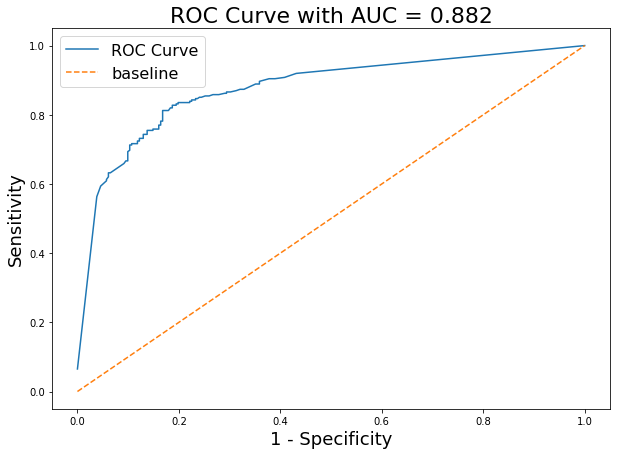

In [70]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## Gridsearch & Pipeline

### Model 1 (CountVectorizer & LogisticRegression)

In [78]:
#Model 1
cvec = CountVectorizer()
lr = LogisticRegression()

In [81]:
pipe = Pipeline([('cvec', cvec), ('lr', lr)])

params = {
        'cvec__max_features': range(4000,5000,6000),
        'cvec__max_df': np.arange(0.8,0.9,0.95),
        'cvec__ngram_range': [(1, 1), (1, 2),(1,3)],
        }

grid_model = GridSearchCV(
    pipe,
    params,
    cv=5,
    n_jobs=3,
)

grid_model.fit(X_train['selftext'], y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [82]:
score = grid_model.score(X_test['selftext'], y_test)
print('score:',score)

print('best_score:', grid_model.best_score_)
print('best_params:', grid_model.best_params_)

score: 0.847036328871893
best_score: 0.7991803278688525
best_params: {'cvec__max_df': 0.8, 'cvec__max_features': 4000, 'cvec__ngram_range': (1, 2)}


# Confusion matrix

In [87]:
grid_pred = grid_model.predict(X_test['selftext'])

tn, fp, fn, tp = confusion_matrix(y_test, grid_pred).ravel()

#Confusion Matrix metrics

accuracy = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

print('\n')

print('Accuracy:',round(accuracy,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))

True Negatives: 229
False Positives: 33
False Negatives: 47
True Positives: 214


Accuracy: 0.847
Sensitivity: 0.82
Specificity: 0.874
Precision: 0.866


### ROC Curve

In [89]:
pred_proba = [i[1] for i in grid_model.predict_proba(X_test['selftext'])] 

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

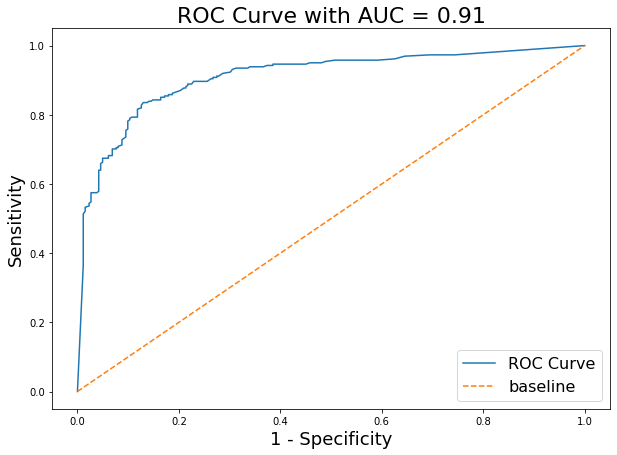

In [90]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

### Model 2 (CountVectorizer & MultinomialNB)

In [92]:
#Model 2
cvec = CountVectorizer()
nb = MultinomialNB()

In [93]:
pipe = Pipeline([('cvec', cvec), ('nb', nb)])

params = {
        'cvec__max_features': range(4000,5000,6000),
        'cvec__max_df': np.arange(0.8,0.9,0.95),
        'cvec__ngram_range': [(1, 1), (1, 2),(1,3)]
        }

grid_model = GridSearchCV(
    pipe,
    params,
    cv=5,
    n_jobs=3,
)

grid_model.fit(X_train['selftext'], y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [94]:
score = grid_model.score(X_test['selftext'], y_test)
print('score:',score)

print('best_score:', grid_model.best_score_)
print('best_params:', grid_model.best_params_)

score: 0.8317399617590823
best_score: 0.8254098360655737
best_params: {'cvec__max_df': 0.8, 'cvec__max_features': 4000, 'cvec__ngram_range': (1, 2)}


### Confusion Matrix

In [95]:
grid_pred = grid_model.predict(X_test['selftext'])

tn, fp, fn, tp = confusion_matrix(y_test, grid_pred).ravel()

#Confusion Matrix metrics

accuracy = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

print('\n')

print('Accuracy:',round(accuracy,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))

True Negatives: 222
False Positives: 40
False Negatives: 48
True Positives: 213


Accuracy: 0.832
Sensitivity: 0.816
Specificity: 0.847
Precision: 0.842


### ROC Curve 

In [96]:
pred_proba = [i[1] for i in grid_model.predict_proba(X_test['selftext'])] 

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

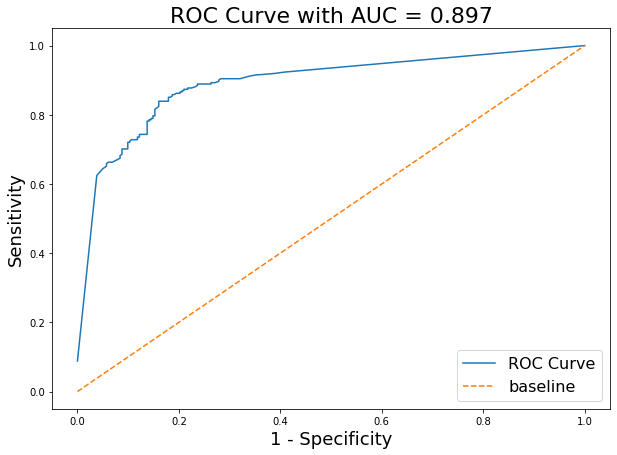

In [97]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);
          

### Model 3 (TfidfVectorizer & LogisticRegression)

In [71]:
#Model 1
tfidf = TfidfVectorizer()
lr = LogisticRegression()

In [72]:
pipe = Pipeline([('tfidf', tfidf), ('lr', lr)])

params = {
        'tfidf__max_features': range(4000,5000,6000),
        'tfidf__max_df': np.arange(0.8,0.9,0.95),
        'tfidf__ngram_range': [(1, 1), (1, 2),(1,3)],
        }

grid_model = GridSearchCV(
    pipe,
    params,
    cv=5,
    n_jobs=3,
)

grid_model.fit(X_train['selftext'], y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [73]:
score = grid_model.score(X_test['selftext'], y_test)
print('score:',score)

print('best_score:', grid_model.best_score_)
print('best_params:', grid_model.best_params_)

score: 0.8546845124282982
best_score: 0.8336065573770493
best_params: {'tfidf__max_df': 0.8, 'tfidf__max_features': 4000, 'tfidf__ngram_range': (1, 1)}


### Confusion matrix

In [74]:
grid_pred = grid_model.predict(X_test['selftext'])

tn, fp, fn, tp = confusion_matrix(y_test, grid_pred).ravel()

#Confusion Matrix metrics

accuracy = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

print('\n')

print('Accuracy:',round(accuracy,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))

True Negatives: 229
False Positives: 33
False Negatives: 43
True Positives: 218


Accuracy: 0.855
Sensitivity: 0.835
Specificity: 0.874
Precision: 0.869


### ROC Curve

In [75]:
pred_proba = [i[1] for i in grid_model.predict_proba(X_test['selftext'])] 

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

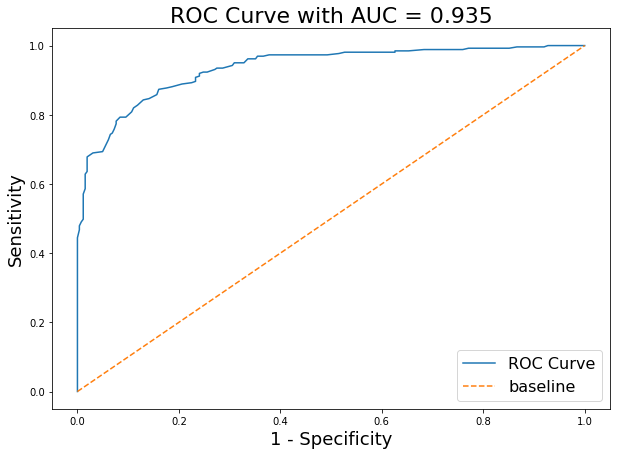

In [76]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

### Model 4 (TfidfVectorizer & MultinomialNB)

In [77]:
#Model 2
tfidf = TfidfVectorizer()
nb = MultinomialNB()

In [78]:
pipe = Pipeline([('tfidf', tfidf), ('nb', nb)])

params = {
        'tfidf__max_features': range(4000,5000,6000),
        'tfidf__max_df': np.arange(0.8,0.9,0.95),
        'tfidf__ngram_range': [(1, 1), (1, 2),(1,3)]
        }

grid_model = GridSearchCV(
    pipe,
    params,
    cv=5,
    n_jobs=3,
)

grid_model.fit(X_train['selftext'], y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [79]:
score = grid_model.score(X_test['selftext'], y_test)
print('score:',score)

print('best_score:', grid_model.best_score_)
print('best_params:', grid_model.best_params_)

score: 0.8240917782026769
best_score: 0.8172131147540984
best_params: {'tfidf__max_df': 0.8, 'tfidf__max_features': 4000, 'tfidf__ngram_range': (1, 2)}


### Confusion Matrix

In [80]:
grid_pred = grid_model.predict(X_test['selftext'])

tn, fp, fn, tp = confusion_matrix(y_test, grid_pred).ravel()

#Confusion Matrix metrics

accuracy = (tp+tn)/(tp+fp+fn+tn)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

print('\n')

print('Accuracy:',round(accuracy,3))
print('Sensitivity:',round(sensitivity,3))
print('Specificity:',round(specificity,3))
print('Precision:',round(precision,3))

True Negatives: 224
False Positives: 38
False Negatives: 54
True Positives: 207


Accuracy: 0.824
Sensitivity: 0.793
Specificity: 0.855
Precision: 0.845


Grid model 1 gives a better accuracy score as compared to Grid model 2.

### ROC Curve

In [81]:
pred_proba = [i[1] for i in grid_model.predict_proba(X_test['selftext'])] 

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

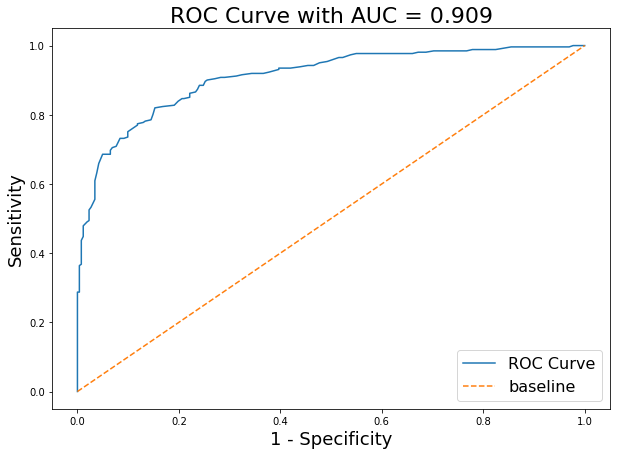

In [82]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);
          
          


## Evaluation Summary

### Model Choice: TfidfVectorizer & LogisticRegression

**TfidfVectorizer & LogisticRegression** was the final choice of our model as it has one of the highest accuracy score as compared to other deployed methods. 


### Data collected from models

|Model      |Accuracy      |ROC AUC 
|---------    |------    |---------|
|**Logistic Regression** |0.8336    |0.907  |
|**MultinomialNB**        |0.8068    |0.882  |
|**CountVectorizer & LogisticRegression** |0.847  |0.91  |
|**CountVectorizer & MultinomialNB**    |0.831    |0.82  |
|**TfidfVectorizer & LogisticRegression** |**0.8546**  |**0.935**  |
|**TfidfVectorizer & MultinomialNB**    |0.8221    |0.908  |

**Accuracy:** TfidfVectorizer & LogisticRegression provided the highest accuracy of **0.8546**.  
**ROC AUC:** TfidfVectorizer & LogisticRegression has **0.935**. This mean that the positive and negative predictions are relatively distinct and there is not much overlapped between them. 


## Conclusion & Recommendation

In conclusion, the sentiment analysis of words used in both the subreddit post are pretty similar. Both are on the extreme side of the score in which their words are mostly very negative(-1) or positive(1). In this case it is possible as we are handling depression and anxiety issue thus, the sentiment within the posts would be relatively negative and at the same time people would be giving positive advise which would form the positive aspect of the posts.

And from the words comparison analysis, both subreddit posts have similar usage of words such as 'feel' and 'people' which are words used to describe feelings and human interactions. Individually, depression have distinct words such as 'friend' and 'life' which is relevant to this situation in which depression patients would normally be discussing about life issues and having friends support. Anxiety has distinct words such as 'feeling' and 'work' and it might be due to the emotional aspect of anxiety disorder patients feeling stress at work or engaging in social ineraction. 

With all the above analysis we decided to implement it into 4 different models and TfidfVectorizer & LogisticRegression gave us the best accuracy and ROC AUC score. Beside having the best score and accuracy the confusion matrix of the model gives the least type 2 error, in which psychiatrist fail to diagnosed an anxiety disorder patient. We feel that failling to diagnose an anxiety disorder patient would be more detrimental as opposed to diagnosing a patient wrongly for anxiety. This would further harm the patient mental health. In conclusion, the final model with TfidfVectorizer & LogisticRegression will be used and recommended for helping psychiatrist to make better deduction of depression or anxiety attack patients.



